# Crisis Impact Analysis

In this notebook, we will analyze the damage caused by the crisis in terms of:

## Key Metrics to Analyze

- **Total Orders Made** - Volume impact over time
- **Order Cancellation Rate** - Percentage of failed orders
- **Revenue Generated** - Total income from orders
- **Revenue from Cancelled Orders** - Lost opportunity cost
- **Costs of Cancelled Orders** - Operational expenses

## Time Periods

All metrics will be analyzed across:
- **Monthly breakdown** for 2025
- **Pre-Crisis vs Crisis Era** comparison

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
def load_data(table):
    df = pd.read_csv(f'rpc_18_inputs_for_participants//rpc_18_inputs_for_participants//RPC_18_Datasets//{table}.csv')
    return df

In [110]:
files = ['dim_customer','dim_delivery_partner_','dim_menu_item','dim_restaurant','fact_delivery_performance','fact_order_items','fact_orders','fact_ratings']

In [111]:
orders = load_data('fact_orders')
orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N


## Data Preparation

For this analysis, we primarily need:
- **Month** - To aggregate data by time period
- **Hour** - To identify peak ordering times

In [112]:
orders['order_timestamp'] = pd.to_datetime(orders['order_timestamp'])

In [113]:
orders.info()

<class 'pandas.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             149166 non-null  str           
 1   customer_id          149166 non-null  str           
 2   restaurant_id        149166 non-null  str           
 3   delivery_partner_id  143531 non-null  str           
 4   order_timestamp      149166 non-null  datetime64[us]
 5   subtotal_amount      149166 non-null  float64       
 6   discount_amount      149166 non-null  float64       
 7   delivery_fee         149166 non-null  float64       
 8   total_amount         149166 non-null  float64       
 9   is_cod               149166 non-null  str           
 10  is_cancelled         149166 non-null  str           
dtypes: datetime64[us](1), float64(4), str(6)
memory usage: 12.5 MB


In [114]:
orders['month'] = orders['order_timestamp'].dt.month

In [115]:
orders['year'] = orders['order_timestamp'].dt.year
orders['year'].value_counts()

year
2025    149166
Name: count, dtype: int64

## Year Filtering

> **Note:** The year column contains only 2025 data, so it can be safely ignored in this analysis.

In [116]:
orders.drop(['year'],axis=1,inplace=True)

In [117]:
orders['month'].value_counts()

month
3    23543
1    23539
2    22667
5    22591
4    21466
6     9293
7     8818
9     8694
8     8555
Name: count, dtype: int64

In [118]:
orders['order_timestamp'].dt.hour.value_counts()

order_timestamp
19    22445
22    22380
20    22252
21    22161
13    19989
14    19977
12    19962
Name: count, dtype: int64

## Monthly Order Analysis

Let's examine the total orders placed in each month for 2025 and identify trends.

In [119]:
# pretty bad code this one 

# successfull_orders = orders[orders['is_cancelled'] =='N']

# failed_orders = orders[orders['is_cancelled'] !='N']



# trend_success= successfull_orders.groupby(['month'])['order_id'].count().pct_change()*100

# total_sucess = successfull_orders.groupby(['month'])['order_id'].count()

# trend_failed= failed_orders.groupby(['month'])['order_id'].count().pct_change()*100

# total_failed = failed_orders.groupby(['month'])['order_id'].count()



# orders_decline_delivered = pd.DataFrame({

#     'total_orders':total_orders,

#     'trend_overall':trend,

#     'total_sucess':total_sucess,

#     'trend_sucess':trend_success,

#     'trend_failed':trend_failed,
#     'total_failed':total_failed,
#     'pct_failed':(total_orders/total_failed)*100
#     })
# orders_decline_delivered

## Optimizing the Analysis

Refactoring the approach for cleaner, more maintainable code using grouped aggregations.

In [123]:
monthly_stats=(
    orders.groupby(['month','is_cancelled'])['order_id']
    .count()
    .unstack()
    .rename(columns={'N':'Sucessfull','Y':'Failed'})
    .rename_axis(None,axis=1)

)
monthly_stats['total_orders'] = monthly_stats['Sucessfull']+monthly_stats['Failed']
monthly_stats['order_trend'] = monthly_stats['total_orders'].pct_change()*100
monthly_stats['fail_pct'] = (monthly_stats['Failed']/monthly_stats['total_orders'])*100


monthly_stats

,Sucessfull,Failed,total_orders,order_trend,fail_pct
month,,,,,
1,22076,1463,23539,NaN,6.215217
2,21272,1395,22667,-3.704490,6.154321
3,22133,1410,23543,3.864649,5.989041
4,20210,1256,21466,-8.822155,5.851113
5,21221,1370,22591,5.240846,6.064362
6,8219,1074,9293,-58.864149,11.557086
7,7768,1050,8818,-5.111374,11.907462
8,7485,1070,8555,-2.982536,12.507306
9,7670,1024,8694,1.624781,11.778238


## Key Metrics Selection

**Critical Metrics Identified:**

| Metric | Importance | Reason |
|--------|-----------|--------|
| **Total Orders** | ⭐⭐⭐ | Core volume indicator for brand success |
| **Order Trend (MoM %)** | ⭐⭐⭐ | Growth trajectory and crisis severity |
| **Failure Percentage** | ⭐⭐⭐ | Service quality indicator |

**Redundant Metrics (Removed):**
- Individual success/failure counts (conveyed by aggregated metrics above)

In [124]:
monthly_stats_finalized = monthly_stats[['total_orders','order_trend','fail_pct']]
monthly_stats_finalized

,total_orders,order_trend,fail_pct
month,,,
1,23539,NaN,6.215217
2,22667,-3.704490,6.154321
3,23543,3.864649,5.989041
4,21466,-8.822155,5.851113
5,22591,5.240846,6.064362
6,9293,-58.864149,11.557086
7,8818,-5.111374,11.907462
8,8555,-2.982536,12.507306
9,8694,1.624781,11.778238


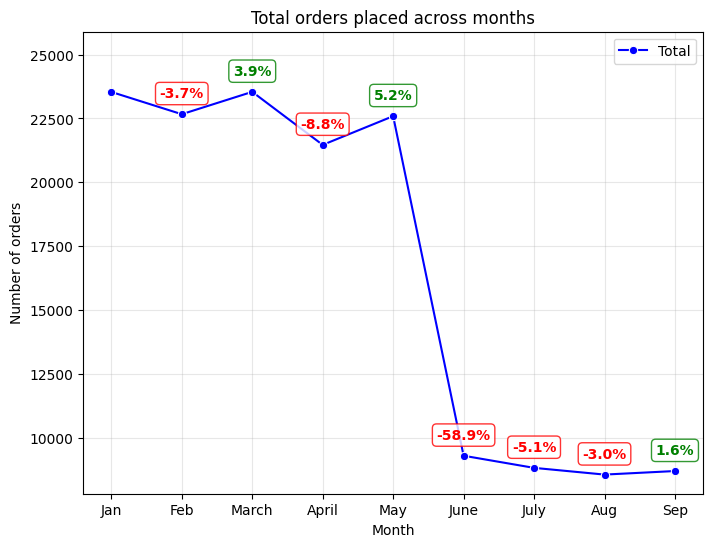

In [187]:
plt.figure(figsize=(8,6))
sns.lineplot(data= monthly_stats_finalized,x = 'month',y='total_orders',marker='o',color='b', label = 'Total')

for i,row in monthly_stats_finalized.iterrows():
    if pd.notnull(row['order_trend']):
        color_logic = 'green' if row['order_trend'] >=0 else 'red'

        plt.annotate(
            f'{row['order_trend']:.1f}%',
            xy = (i,row['total_orders']),
            xytext = (0,12),
            textcoords = 'offset points',
            color = color_logic,
            ha='center',
            fontweight='bold',
            bbox=dict(boxstyle='round', fc='white', ec=color_logic, alpha=0.8)

        )
plt.title('Total orders placed across months')
plt.xlabel('Month')
plt.xticks([1,2,3,4,5,6,7,8,9],['Jan','Feb','March','April','May','June','July','Aug','Sep'])
plt.ylabel('Number of orders')
plt.grid(alpha=0.3)
plt.ylim(top=monthly_stats_finalized['total_orders'].max()*1.1)
plt.legend()

plt.show()


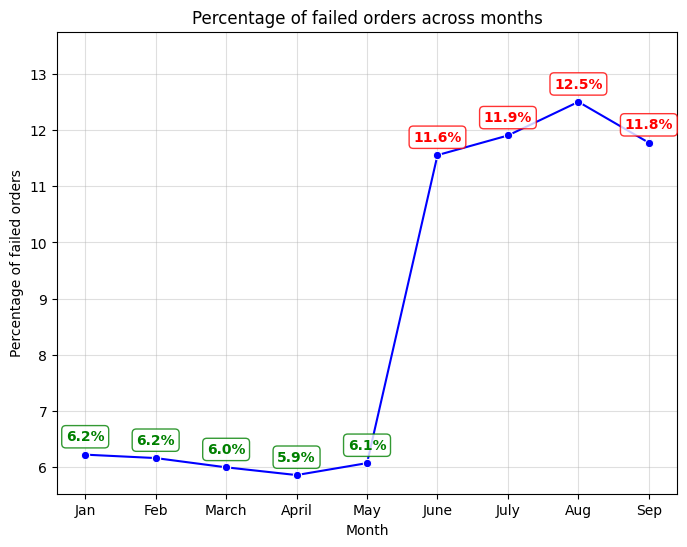

In [189]:
plt.figure(figsize=(8,6))

sns.lineplot(data=monthly_stats_finalized,x='month',y='fail_pct', marker='o', color='b')

for i,row in monthly_stats_finalized.iterrows():
    color_logic = 'green' if row['fail_pct'] <10 else 'red'
    plt.annotate(
        f'{row['fail_pct']:.1f}%',
        xy = (i,row['fail_pct']),
        xytext = (0,10),
        textcoords = 'offset points',
        ha = 'center',
        fontweight = 'bold',
        color = color_logic,
        bbox = dict(boxstyle='round',fc='white', ec = color_logic, alpha=0.8)
    )

plt.title('Percentage of failed orders across months')
plt.xticks(monthly_stats_finalized.index,['Jan','Feb','March','April','May','June','July','Aug','Sep'])

plt.xlabel('Month')
plt.ylabel('Percentage of failed orders')
plt.grid(alpha=0.4)

plt.ylim(top = monthly_stats_finalized['fail_pct'].max()*1.1)
plt.show()
